# SNN that detects Network bursts in a single channel
This notebook is a simple example of how to use a Spiking Neural Network (SNN) to detect network bursts in a single channel. 

## Definition of a network burst
A network burst is a sequence of spikes that occur in a short time window. The definition of a network burst is not unique and depends on the context. 

In this notebook, we will **consider a network burst any sequence of 4 or more spikes that occurs within 20 ms**

In [57]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

In [58]:
# Define the number of neurons in each LIF Layer
n1 = 8   # Let's create a simple program with only 1 LIF layer

## Choose the LIF Models to use

In [59]:
import numpy as np

use_refractory = True

### Create the LIF Processes

In [60]:
v_th = 1
v_init = 0
dv = 0.1
du = 0.2

if not use_refractory:
    # Create Processes
    lif1 = LIF(shape=(n1,),  # There are 2 neurons
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv,    # Inverse of decay time-constant for voltage decay
            du=du,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            name="lif1")

### Create the Refractory LIF Processes

In [61]:
from lava.proc.lif.process import LIFRefractory
from lava.magma.core.process.process import LogConfig
import logging

# Constants for the LIF Process
v_th = 1.0
v_init = 0.0
dv = 0.1
du = 0.2
refrac_period = 20   # Number of time-steps for the refractory period

if use_refractory:
    # Create Refractory LIF1 process
    lif1 = LIFRefractory(shape=(n1,),  # There are 2 neurons
            vth=v_th,  # TODO: Verify these initial values
            v=v_init,
            dv=dv,    # Inverse of decay time-constant for voltage decay
            du=du,  # Inverse of decay time-constant for current decay
            bias_mant=0,
            bias_exp=0,
            refractory_period=refrac_period,
            name="lif1",
            # log_config=LogConfig(level=logging.DEBUG, level_console=logging.DEBUG, logs_to_file=False)
            )

In [62]:
for proc in [lif1]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: lif1  Port Name: a_in  Size: 8
Proc: lif1  Port Name: s_out Size: 8


## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [63]:
import os
import sys

# Add the parent directory to the path so it detects the utils module
module_path = os.path.abspath(os.path.join('..'))   
if module_path not in sys.path:
    sys.path.append(module_path)

In [64]:
from utils.input import read_spike_events

# Call the function to read the spike events
file_path = "../lab_data/lab_data_1-8channels.csv"    # "./data/custom_frequent_spikes.csv"
spike_events = read_spike_events(file_path)
print("Spike events: ", spike_events.shape, spike_events[:10])

Spike events:  (3380, 2) [[3.0360e+02 7.0000e+00]
 [5.4090e+02 7.0000e+00]
 [7.8260e+02 7.0000e+00]
 [1.0638e+03 7.0000e+00]
 [1.4271e+03 1.0000e+00]
 [1.4304e+03 1.0000e+00]
 [1.4333e+03 1.0000e+00]
 [1.4347e+03 7.0000e+00]
 [1.4628e+03 1.0000e+00]
 [2.0500e+03 7.0000e+00]]


### Define the SpikeEvent Generator Interface

In [65]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        shape (tuple): Shape of the output port
        file_name (str): Name of the file containing the spike events
    """
    def __init__(self, shape: tuple, spike_events: np.ndarray, name: str) -> None:
        super().__init__(name=name)
        self.s_out = OutPort(shape=shape)
        self.spike_events = Var(shape=spike_events.shape, init=spike_events)

### Map the input channels to the corresponding indexes in the input layer
Since the input channels in the input file may be of any number, we need to map the input channels to the corresponding indexes in the input layer. This is done by the `channel_map` dictionary.

In [66]:
# Map the channels of the input file to the respective index in the output list of SpikeEventGen
channel_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}

## Define constants related to the simulation time

In [67]:
init_offset = 5800      #  
virtual_time_step_interval = 1

num_steps = 300     # Number of steps to run the simulation

### Implement the `SpikeEventGenerator` Model

In [68]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)   # TODO: Check if we should keep it as a numpy array, or transform it to a list

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        # print("spike events", self.spike_events.__str__())    # TODO: Check why during initialization the variable prints the class, while during run it prints the value
        self.curr_spike_idx = 0     # Index of the next spiking event to send
        self.virtual_time_step_interval = virtual_time_step_interval  # 1000    # Arbitrary time between time steps (in microseconds). This is not a real time interval (1000ms = 1s)
        self.init_offset = init_offset        # 698995               # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        # Use random spikes to test it
        # spike_data[0] = np.random.random()  # Only 1 neuron is sending data (spikes)
        # self.curr_spike_idx += 1

        # Use the spike events from the file
        # print("spike events: ", self.spike_events[:5])
        # TODO: For now we are using the time_step as the time measurement that will simulate real-time activity. It would be better to have access to the running time
        
        #print("time step:", self.time_step)
        # If the current simulation time is greater than the next spike event, send a spike
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval

        spiking_channels = set()   # List of channels that will spike at the same time
        while (self.curr_spike_idx < len(self.spike_events)) and currTime >= self.spike_events[self.curr_spike_idx][0]:  # Check if there are more than 1 spike events to send
            curr_channel = self.spike_events[self.curr_spike_idx][1]

            # Check if the next spike belongs to a channel that will already spike at the same time
            if curr_channel in spiking_channels:    # If the channel is already spiking, we stop the spikes for this time step
                break

            # Add the channel to the list of spiking channels
            spiking_channels.add(curr_channel)

            # Send a spike
            out_idx = channel_map[curr_channel]     # Map the channel to the output index
            if out_idx < self.s_out.shape[0]:   # Check if the channel is valid
                spike_data[out_idx] = 1.0   # Send a spike  (value corresponds to the punctual current of the spike event)

            # Move to the next spike event
            self.curr_spike_idx += 1

        if len(spiking_channels) > 0:   # Print the spike event if there are any spikes
            print(f"sending spike event at time: {currTime}({self.time_step}) last spike idx: {self.curr_spike_idx-1} spike time: {self.spike_events[self.curr_spike_idx-1][0]}")

        # Send spikes
        # print("sending spike_data: ", spike_data, " at step: ", self.time_step)
        self.s_out.send(spike_data)

        # Stop the Process if there are no more spike events to send. (It will stop all the connected processes)
        # TODO: Should it be another process that stops the simulation? Such as the last LIF process
        # if self.curr_spike_idx >= 5: # len(self.spike_events):
        #    self.pause()


## Connect the Custom Input Layer to the middle layer

To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we use another `Dense` Layer.

In [69]:
# Create the Input Process
spike_event_gen = SpikeEventGen(shape=(n1,), spike_events=spike_events, name="CustomInput")


# create weights of the dense layer
dense_weights = np.eye(N=n1, M=n1)
# multiply the weights of the Dense layer by a constant
weights_scale = 0.1
dense_weights *= weights_scale

dense_input = Dense(weights=np.array(dense_weights), name="DenseInput")

# TODO: NOTE: There is a LearningDense process that could be interesting

# If I connect the SpikeEventGen to the Dense Layer, the a_out value of the custom input will be rounded to 0 or 1 in the Dense Layer (it will not be a float) 
# However, setting the Dense weights to a float works instead
# Connect the SpikeEventGen to the Dense Layer
spike_event_gen.s_out.connect(dense_input.s_in)

# Connect the Dense_Input to the LIF1 Layer
dense_input.a_out.connect(lif1.a_in)

### Take a look at the connections in the Input Layer

In [70]:
for proc in [spike_event_gen, dense_input, lif1]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: CustomInput Port Name: s_out Size: 8
Proc: DenseInput Port Name: s_in  Size: 8
Proc: DenseInput Port Name: a_out Size: 8
Proc: lif1  Port Name: a_in  Size: 8
Proc: lif1  Port Name: s_out Size: 8


In [71]:
# Weights of the Input Dense Layer
dense_input.weights.get()

array([[0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1]])

### Record Internal Vars over time
To record the evolution of the internal variables over time, we need a `Monitor`. For this example, we want to record the membrane potential of the `LIF` Layer, hence we need 1 `Monitors`.

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function

In [72]:
from lava.proc.monitor.process import Monitor

monitor_lif1_v = Monitor()
monitor_lif1_u = Monitor()

# Connect the monitors to the variables we want to monitor
monitor_lif1_v.probe(lif1.v, num_steps)
monitor_lif1_u.probe(lif1.u, num_steps)

## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [73]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

### Execute

In [74]:
lif1.run(condition=run_condition, run_cfg=run_cfg)

sending spike event at time: 5801(1) last spike idx: 0 spike time: 303.6
sending spike event at time: 5802(2) last spike idx: 1 spike time: 540.9
sending spike event at time: 5803(3) last spike idx: 2 spike time: 782.6
sending spike event at time: 5804(4) last spike idx: 4 spike time: 1427.1
sending spike event at time: 5805(5) last spike idx: 5 spike time: 1430.4
sending spike event at time: 5806(6) last spike idx: 7 spike time: 1434.7
sending spike event at time: 5807(7) last spike idx: 9 spike time: 2050.0
sending spike event at time: 5808(8) last spike idx: 10 spike time: 2052.3
sending spike event at time: 5809(9) last spike idx: 12 spike time: 2791.1
sending spike event at time: 5810(10) last spike idx: 15 spike time: 2794.2000000000003
sending spike event at time: 5811(11) last spike idx: 16 spike time: 2800.6
sending spike event at time: 5812(12) last spike idx: 17 spike time: 2874.1
sending spike event at time: 5813(13) last spike idx: 19 spike time: 2884.5
sending spike event

### Retrieve recorded data

In [75]:
data_lif1_v = monitor_lif1_v.get_data()
data_lif1_u = monitor_lif1_u.get_data()

data_lif1 = data_lif1_v.copy()
data_lif1["lif1"]["u"] = data_lif1_u["lif1"]["u"]   # Merge the dictionaries to contain both voltage and current


In [76]:
data_lif1

{'lif1': {'v': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 1.00000000e-01, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 2.70000000e-01, 0.00000000e+00],
         ...,
         [9.27833887e-04, 0.00000000e+00, 0.00000000e+00, ...,
          5.22329880e-09, 4.26694334e-04, 2.52093142e-09],
         [8.35120886e-04, 0.00000000e+00, 0.00000000e+00, ...,
          4.70096892e-09, 3.84027054e-04, 2.26883828e-09],
         [7.51665107e-04, 0.00000000e+00, 0.00000000e+00, ...,
          4.23087203e-09, 3.45626071e-04, 2.04195445e-09]]),
  'u': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 1.00000000e-01, 0.00000

In [77]:
# Check the shape to verify if it is printing the voltage for every step
len(data_lif1['lif1']['v'])     # Indeed, there are 300 values (same as the number of steps we ran the simulation for)

300

### Plot the recorded data

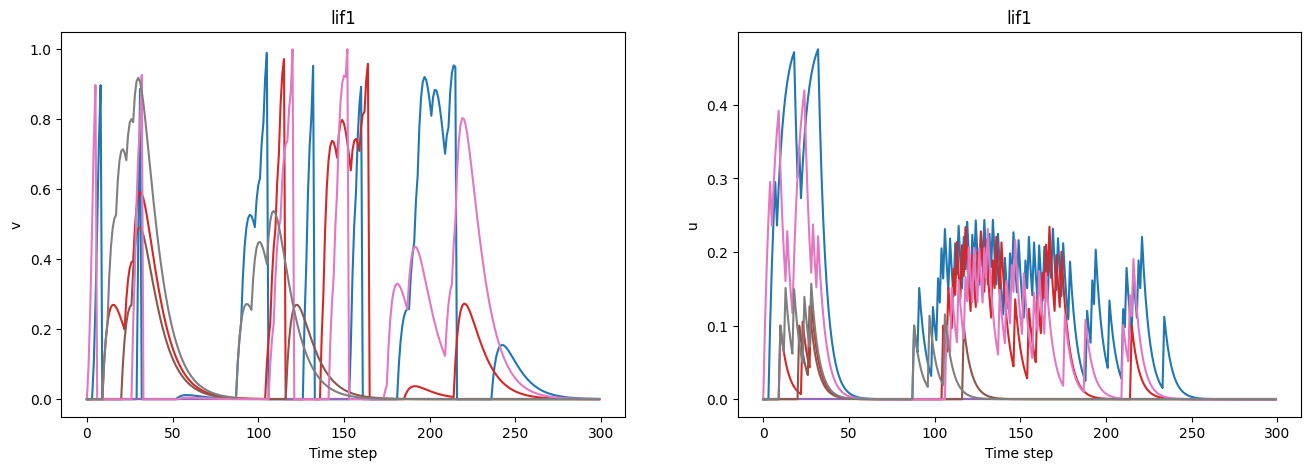

In [78]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax0.set_title('Voltage (V) / time step')
ax1 = fig.add_subplot(122)
ax1.set_title('Current (U) / time step')

# Plot the data
monitor_lif1_v.plot(ax0, lif1.v)
monitor_lif1_u.plot(ax1, lif1.u)


## Find the timesteps where the network bursts occur

In [79]:
from utils.data_analysis import find_spike_times

voltage_arr = np.array(data_lif1['lif1']['v'])
print("voltage_arr shape:", voltage_arr.shape)

spike_times = find_spike_times(voltage_arr, v_th)

print("Spike times: ", spike_times)

voltage_arr shape: (300, 8)
Spike times:  [6, 9, 32, 33, 106, 116, 121, 133, 153, 161, 165, 216]


## Observations

- Why is the membrane potential of the LIF neurons not reaching the threshold and firing anyway?
  - Is it because it would spike in the next time step?


## View the Voltage and Current dynamics with an interactive plot

Grab the data from the recorded variables

In [80]:
lif1_voltage_vals = data_lif1['lif1']['v']
lif1_current_vals = data_lif1['lif1']['u']

print("v_ch0 shape:", len(lif1_voltage_vals))

# print("voltage head: ", lif1_voltage_vals[:10])

v_ch0 shape: 300


## Assemble the values to be plotted

In [81]:
from utils.line_plot import create_fig  # Import the function to create the figure
from bokeh.models import Range1d

# Define the x and y values
x = [val + init_offset for val in range(num_steps)]

v_y1 = [val[0] for val in lif1_voltage_vals]
v_y2 = [val[1] for val in lif1_voltage_vals]
v_y3 = [val[2] for val in lif1_voltage_vals]
v_y4 = [val[3] for val in lif1_voltage_vals]
v_y5 = [val[4] for val in lif1_voltage_vals]
v_y6 = [val[5] for val in lif1_voltage_vals]
v_y7 = [val[6] for val in lif1_voltage_vals]
v_y8 = [val[7] for val in lif1_voltage_vals]

# Create the plot
voltage_lif1_y_arrays = [(v_y1, "Ch. 1"), (v_y2, "Ch. 2"), (v_y3, "Ch. 3"), (v_y4, "Ch. 4"), 
                         (v_y5, "Ch. 5"), (v_y6, "Ch. 6"), (v_y7, "Ch. 7"), (v_y8, "Ch. 8")]    # List of tuples containing the y values and the legend label
# Define the box annotation parameters
box_annotation_voltage = {
    "bottom": 0,
    "top": v_th,
    "left": 0,
    "right": num_steps,
    "fill_alpha": 0.03,
    "fill_color": "green"
}

# Create the LIF1 Voltage
voltage_lif1_plot = create_fig(
    title="LIF1 Voltage dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Voltage (V)',
    x=x, 
    y_arrays=voltage_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    box_annotation_params=box_annotation_voltage,
    y_range=Range1d(-0.05, 1.05)
)


# Create the LIF1 Current
u_y1 = [val[0] for val in lif1_current_vals]
u_y2 = [val[1] for val in lif1_current_vals]
u_y3 = [val[2] for val in lif1_current_vals]
u_y4 = [val[3] for val in lif1_current_vals]
u_y5 = [val[4] for val in lif1_current_vals]
u_y6 = [val[5] for val in lif1_current_vals]
u_y7 = [val[6] for val in lif1_current_vals]
u_y8 = [val[7] for val in lif1_current_vals]
current_lif1_y_arrays = [(u_y1, "Ch. 1"), (u_y2, "Ch. 2"), (u_y3, "Ch. 3"), (u_y4, "Ch. 4"),
                         (u_y5, "Ch. 5"), (u_y6, "Ch. 6"), (u_y7, "Ch. 7"), (u_y8, "Ch. 8")]    # List of tuples containing the y values and the legend label
current_lif1_plot = create_fig(
    title="LIF1 Current dynamics", 
    x_axis_label='time (ms)', 
    y_axis_label='Current (U)',
    x=x, 
    y_arrays=current_lif1_y_arrays, 
    sizing_mode="stretch_both", 
    tools="pan, box_zoom, wheel_zoom, hover, undo, redo, zoom_in, zoom_out, reset, save",
    tooltips="Data point @x: @y",
    legend_location="top_right",
    legend_bg_fill_color="navy",
    legend_bg_fill_alpha=0.1,
    x_range=voltage_lif1_plot.x_range,    # Link the x-axis range to the voltage plot
)

# bplt.show(voltage_lif1_plot)

## Show the Plots assembled in a grid

In [82]:
import bokeh.plotting as bplt
from bokeh.layouts import gridplot

showPlot = True
if showPlot:
    # Create array of plots to be shown
    plots = [voltage_lif1_plot, current_lif1_plot]

    if len(plots) == 1:
        grid = plots[0]
    else:   # Create a grid layout
        grid = gridplot(plots, ncols=2, sizing_mode="stretch_both")

    # Show the plot
    bplt.show(grid)

## Export the plot to a file

In [83]:
export = True

if export:
    file_path = "./results/lab_ch1-8_4spikes_20ms_20refrac_1_0_0.1_0.2.html"

    # Customize the output file settings
    bplt.output_file(filename=file_path, title="Channel Burst detection - LIF1 Voltage and Current dynamics")

    # Save the plot
    bplt.save(grid)

## Stop the Runtime

In [84]:
lif1.stop()